In [145]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import os
import torch
from torch import Tensor
import numpy as np
import time

import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.utils import get_original_cwd, to_absolute_path

import logging

from sbi.inference import MCMCPosterior
from sbi.utils import mcmc_transform
from sbi.utils.metrics import c2st as C2ST

from pathlib import Path

# Algorithm imports.
from sbi.inference import SNPE, SNLE, likelihood_estimator_based_potential
from gbi.GBI import GBInference
import gbi.utils.utils as gbi_utils

# Task imports.
from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture
from gbi import distances

import pandas as pd

In [118]:
def sample_GBI(inference, x_o, beta, task, n_samples=10_000):
    potential_fn = inference.get_potential(x_o=x_o, beta=beta)
    theta_transform = mcmc_transform(task.prior)
    posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=task.prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=50,
            num_chains=100,
            init_strategy="resample",
        )
    posterior_samples = posterior.sample((n_samples,))
    return posterior_samples

def sample_NPE(inference, x_o, task, n_samples=10_000):
    return inference.build_posterior(prior=task.prior).set_default_x(x_o).sample((n_samples,))

# inference_nle = gbi_utils.pickle_load(inference_folder + f'NLE.pickle')
# def sample_NLE(inference, x_o, beta, task, n_samples=10_000):
#     potential_fn, parameter_transform = likelihood_estimator_based_potential(
#     inference_nle._neural_net, task.prior, x_o
#     )
#     potential_fn = inference.get_potential(x_o=x_o, beta=beta)
#     theta_transform = mcmc_transform(task.prior)
#     posterior = MCMCPosterior(
#             potential_fn,
#             theta_transform=theta_transform,
#             proposal=task.prior,
#             method="slice_np_vectorized",
#             thin=10,
#             warmup_steps=50,
#             num_chains=100,
#             init_strategy="resample",
#         )
#     posterior_samples = posterior.sample((n_samples,))
#     return posterior_samples

In [32]:
task_name = "uniform_1d"
seed = 0
is_specified = 'specified'
is_known = 'known'
xo_idx = 0
beta = 4


In [185]:

# Get high-level path.
# dir_path = get_original_cwd()

dir_path = '../gbi/benchmark/run_algorithms/'
full_path_prepend = f"{dir_path}/../tasks/{task_name}/"
print(full_path_prepend)

# Get inference directory.
inference_folder = full_path_prepend + "/trained_inference/"    

# Get observation directory.
observation_folder = full_path_prepend + "/xos/"

# Get GT sample directory.
gt_folder = f'../results/benchmark/ground_truths/{task_name}/2023_01_23__17_34_09/'

### Define task and distance function.
distance_func = distances.mse_dist
if task_name == "linear_gaussian":
    Task = LinearGaussian
elif task_name == "two_moons":
    Task = TwoMoonsGBI
elif task_name == "uniform_1d":
    Task = UniformNoise1D
elif task_name == "gaussian_mixture":
    Task = GaussianMixture
    distance_func = distances.mmd_dist
else:
    raise NameError

### Sample and simulate from task.
# Set seed
if seed is None:
    seed = int((time.time() % 1) * 1e7)
else:
    seed = seed
# np.savetxt(full_path_prepend + "seed.txt", np.asarray([seed]))

collector = []
for xo_idx in range(2):
    for is_specified in ['specified', 'misspecified']:
        for is_known in ['known', 'unknown']:
            # Sample and simulate.
            _ = torch.manual_seed(seed)
            _ = np.random.seed(seed=seed)

            # Ground-truth samples.
            posterior_samples_gt = gbi_utils.pickle_load(gt_folder + f'/beta_{beta}/obs_{xo_idx}_{is_specified}_{is_known}/rejection_samples.pkl')

            # Set ground-truth task.
            x_os = gbi_utils.pickle_load(observation_folder + f'/xo_{is_specified}_{is_known}.pkl')
            x_o = x_os[xo_idx]
            task = Task(seed=seed, x_o=x_o, beta=beta)

            # Load inference object.
            inference_gbi = gbi_utils.pickle_load(inference_folder + f'GBI.pickle')
            inference_npe = gbi_utils.pickle_load(inference_folder + f'NPE.pickle')

            # Sample.
            posterior_samples_gbi = sample_GBI(inference_gbi, x_o, beta, task, 10_000)
            posterior_samples_npe = sample_NPE(inference_npe, x_o, task, 10_000)

            # Evaluate.
            # C2ST GBI vs. GT
            c2st = C2ST(posterior_samples_gbi, posterior_samples_gt)

            # Posterior predictive distance.
            ppd_gt = distance_func(task.simulate(posterior_samples_gt).unsqueeze(1), x_o)
            ppd_gbi = distance_func(task.simulate(posterior_samples_gbi).unsqueeze(1), x_o)
            ppd_npe = distance_func(task.simulate(posterior_samples_npe).unsqueeze(1), x_o)

            # Collect.
            summary = [task_name, is_specified, is_known, xo_idx, beta, 
                       float(c2st.squeeze()), float(ppd_gt.mean()), float(ppd_gt.std()), float(ppd_npe.mean()), float(ppd_npe.std()), float(ppd_gbi.mean()), float(ppd_gbi.std())]
            collector.append(summary)

../gbi/benchmark/run_algorithms//../tasks/uniform_1d/


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [186]:
col_names = ['task', 'is_specified', 'is_known', 'obs_idx', 'beta', 'c2st', 'ppd_gt_mean', 'ppd_gt_std','ppd_npe_mean', 'ppd_npe_std','ppd_gbi_mean', 'ppd_gbi_std']
dtypes = [str, str, str, int, float, float, float, float, float, float, float, float]
df_summary = pd.DataFrame(np.array(collector), columns=col_names)
df_summary = df_summary.astype({col_names[i]: dtypes[i] for i in range(len(col_names))})
df_summary


# plt.hist(ppd_gbi.squeeze(), 100);
# plt.hist(ppd_npe.squeeze(), 100);
# c2st

,task,is_specified,is_known,obs_idx,beta,c2st,ppd_gt_mean,ppd_gt_std,ppd_npe_mean,ppd_npe_std,ppd_gbi_mean,ppd_gbi_std
0,uniform_1d,specified,known,0,4.0,0.50015,0.063430,0.079582,0.045597,0.056811,0.064272,0.081837
1,uniform_1d,specified,unknown,0,4.0,0.50245,0.080202,0.105871,0.039740,0.054657,0.080935,0.108326
2,uniform_1d,misspecified,known,0,4.0,0.50220,0.307024,0.237235,0.159092,0.115393,0.308767,0.240647
3,uniform_1d,misspecified,unknown,0,4.0,0.50560,0.563630,0.439623,0.139157,0.161939,0.570207,0.448708
4,uniform_1d,specified,known,1,4.0,0.49585,0.060649,0.076807,0.043905,0.054379,0.061604,0.078120
5,uniform_1d,specified,unknown,1,4.0,0.50425,0.103584,0.132468,0.042284,0.057984,0.106954,0.136641
6,uniform_1d,misspecified,known,1,4.0,0.51115,0.244901,0.216994,0.110299,0.095536,0.246576,0.220462
7,uniform_1d,misspecified,unknown,1,4.0,0.50205,0.248264,0.219048,0.112151,0.095462,0.248766,0.218832


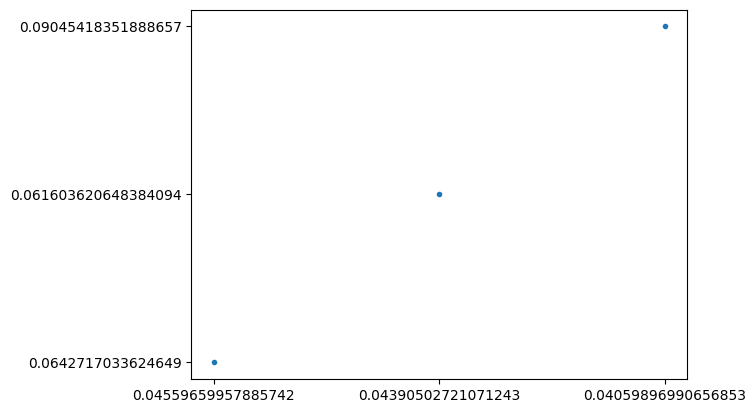

In [170]:
plt.plot(df_summary['ppd_npe_mean'].values, df_summary['ppd_gbi_mean'].values, '.')

In [117]:

def tempered_potential(potential_fn, beta):
    return potential_fn(posterior_samples)

tensor([-0.4540, -0.4283, -0.3058,  ..., -0.3525, -0.3588, -0.6657],
       grad_fn=<AddBackward0>)

In [94]:
posterior_predictives = task.simulate(posterior_samples)

(tensor([0.0069, 0.0276, 0.0002,  ..., 0.0494, 0.0203, 0.0225]),
 tensor([0.0069, 0.0276, 0.0002,  ..., 0.0494, 0.0203, 0.0225]))

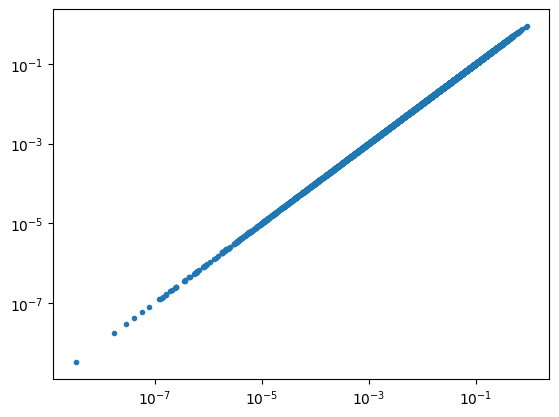

In [97]:

ppd = distance_func(posterior_predictives.unsqueeze(1), x_o)

plt.loglog(ppd, (posterior_predictives-x_o).pow(2).mean(1), '.')
ppd, (posterior_predictives-x_o).pow(2).mean(1)

In [69]:
c2st(posterior_samples, gt_samples)

tensor([0.8349])

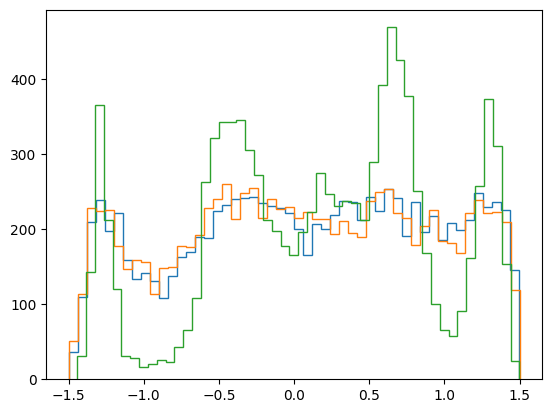

In [107]:
# plt.plot(gt_samples, torch.ones(gt_samples.size()), '.', alpha=0.1)
plt.hist(gt_samples.numpy().squeeze(), 50, histtype='step');
plt.hist(posterior_samples.numpy().squeeze(), 50, histtype='step');
plt.hist(posterior_samples_npe.numpy().squeeze(), 50, histtype='step');

# c2st(posterior_samples, gt_samples)

In [ ]:
task = UniformNoise1D()

# Train inference algorithms.
task.dist_func_gbi = distance_func

# Get trained inference object.
inference = gbi_utils.pickle_load(inference_folder + 'NPE.pickle')
print(inference)